# Load Data

In [13]:
import pyogrio
import geopandas as gpd
gpd.options.io_engine = "pyogrio"
gdf = gpd.read_parquet("py_output/survey_points_MGA2020.parquet")


# Config

In [14]:
resolution = 1
buffer = 5
power = 2
neighbours = 12

# Basic Raster

This first raster is a boolean raster.

* 1: A sample exists in this cell
* 0: otherwise

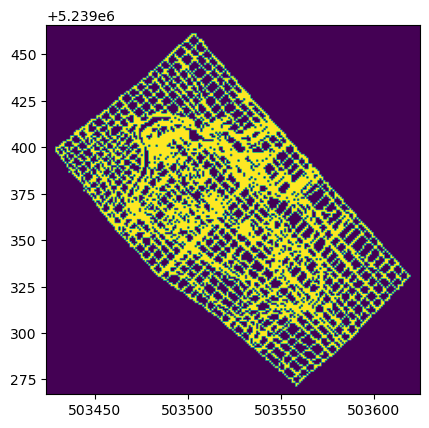

<Axes: >

In [15]:
import math
import numpy as np
import rasterio
import rasterio.plot
import rasterio.transform

minx, miny, maxx, maxy = gdf.total_bounds

resolution = 1
buffer = 5

minx -= buffer
maxx += buffer
miny -= buffer
maxy += buffer

# x_vals = np.arange(minx, maxx, resolution)
cols = math.ceil((maxx - minx) / resolution)

# y_vals = np.arange(miny, maxy, resolution)
rows = math.ceil((maxy - miny) / resolution)

def x_index(x_coord):
    return math.floor( (x_coord - minx) / resolution )

def y_index(y_coord):
    return rows - math.ceil( (y_coord - miny) / resolution )

def xy_index(point):
    return (x_index(point.x), y_index(point.y))


points_raster = np.zeros((rows, cols), dtype=np.bool_, )

for p in gdf.geometry:
    x, y = xy_index(p)
    # Flip y because our projected coordinate system is opposite 
    # in direction to the raster coordinate system
    points_raster[y][x] = True

transform = rasterio.transform.from_origin(
    west=minx,
    north=maxy,
    xsize=resolution,
    ysize=resolution
)

rasterio.plot.show(points_raster, transform=transform)

# Interpolated DEM

We'll start off like before create a basic raster. Instead of having a 0 or 1, we have a 0 or the elevation of the sample point within each cell.

Note: we are taking the value of only 1 sample point within a cell, with no guarantee as to which one. This is similar to what ArcGIS does.

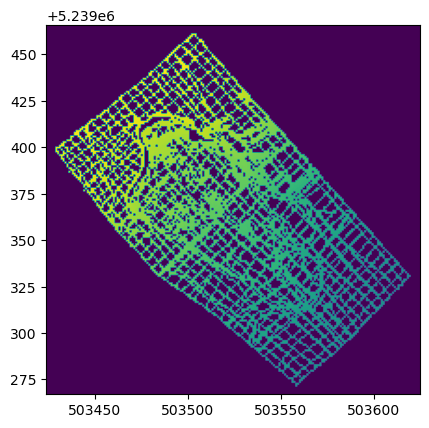

<Axes: >

In [16]:

sample_points_raster = np.zeros((rows, cols), dtype=float)

for p in gdf.geometry:
    x, y = xy_index(p)
    # Flip y because our projected coordinate system is opposite 
    # in direction to the raster coordinate system
    sample_points_raster[y][x] = p.z # z is the elevation

transform = rasterio.transform.from_origin(
    west=minx,
    north=maxy,
    xsize=resolution,
    ysize=resolution
)

rasterio.plot.show(sample_points_raster, transform=transform)

Next I'll create an interpolate function that can calculate the elevation of a cell.

In [17]:
from scipy.spatial import KDTree


sample_coords = gdf['geometry'].apply(lambda point: [point.x, point.y]).to_list()
sample_tree = KDTree(sample_coords)
sample_elevations = gdf['elevation'].to_numpy()

def interpolate_elevation(px, py):
    distances, ndxs = sample_tree.query([px, py], k=neighbours)
    distances[distances == 0] = 1e-10 # this shouldn't be needed
    weights = 1 / (distances ** power)
    nearest_elevations = sample_elevations[ndxs]
    return np.average(nearest_elevations, weights=weights)


Then we'll iterate over each raster cell's center in spatial coordinates and interpolate the elevation.

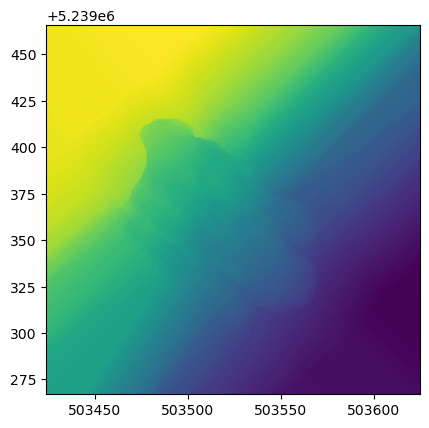

Affine(1.0, 0.0, 503423.84559999965,
       0.0, -1.0, 5239466.0305)

In [18]:
# uncomment resolution later
dem = np.copy(sample_points_raster)

# Get the center of each raster pixel in spatial coords
x_vals = np.arange(minx, maxx, resolution) + 0.5 * resolution
y_vals = np.arange(miny, maxy, resolution) + 0.5 * resolution


for spatial_y in y_vals:
    
    for spatial_x in x_vals:
        raster_x = x_index(spatial_x)
        raster_y = y_index(spatial_y)

        # Skip when there's already a value in the DEM
        if(dem[raster_y][raster_x] == 0):
            elev = interpolate_elevation(spatial_x, spatial_y)
            dem[raster_y][raster_x] = elev       


transform = rasterio.transform.from_origin(
    west=minx,
    north=maxy,
    xsize=resolution,
    ysize=resolution
)
rasterio.plot.show(dem, transform=transform)
transform

## Saving to file

In [19]:
dem_file = rasterio.open(
    'py_output/DEM_IDW_MGA2020.tif', 'w', 
    driver='GTiff',
    height=dem.shape[0],
    width=dem.shape[1],
    count=1,
    dtype=dem.dtype,
    crs=gdf.crs,
    transform=transform
)
dem_file.write(dem, 1)
dem_file.close()